In [1]:
import ee
import geemap
import geopandas as gpd
from shapely.ops import unary_union


In [2]:
#ee.Authenticate()
ee.Initialize()

In [3]:
# Load the shapefile and use it as a region of interest (ROI)
shapefile_path = '/mnt/d/Dropbox/R_projects/SardegnaR/data/Posidonia_olbia/2023/S2_2019.shp'
gdf = gpd.read_file(shapefile_path)

# print names of columns
print(gdf.columns)

Index(['OBJECTID', 'Id', 'gridcode', 'Shape_Leng', 'Shape_Area', 'Id_2',
       'geometry'],
      dtype='object')


<AxesSubplot:>

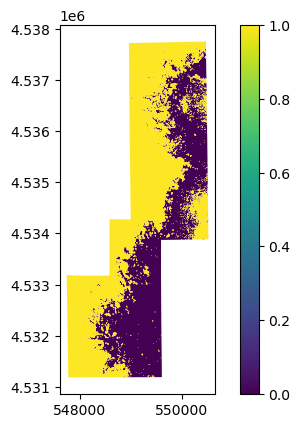

In [4]:

# define field "class", as if id is null = 0, else = 1, then plot it
gdf['class'] = gdf['Id'].isnull().astype(int)
gdf.plot(column='class', legend=True)

In [ ]:
tolerance = 50  # You may need to adjust this value depending on your specific geometry

# Create a new polygon from the outer border of the GeoDataFrame
pol = unary_union(gdf.geometry)

# Simplify the polygon
simplified_polygon = pol.simplify(tolerance)

# Update the GeoDataFrame with the simplified outer border polygon
gdf_simplified = gpd.GeoDataFrame(geometry=[simplified_polygon])

# Simplify the polygon
#simplified_polygon = gdf.simplify(tolerance)
gdf_simplified.plot(column='class', legend=True)


Index(['Id', 'geometry'], dtype='object')


<AxesSubplot:>

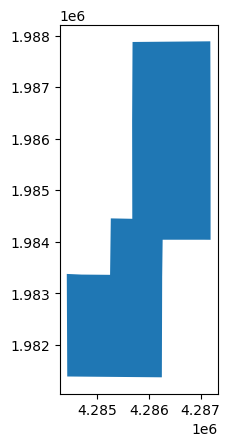

In [5]:
# load also bounding box
# Load the shapefile and use it as a region of interest (ROI)
shapefile_path = '/mnt/d/Dropbox/R_projects/SardegnaR/data/Posidonia_olbia/2023/Aree_lavoro_Olbia/Aree_lavoro_Olbia/Area_lavoro_Olbia_Sentinel-2/Area_lavoro_Olbia_Sentinel.shp'
gdfroi = gpd.read_file(shapefile_path)

# print names of columns
print(gdfroi.columns)

# plot it   
gdfroi.plot()

In [6]:
# define roi from gdfroi for gee
roi = geemap.geopandas_to_ee(gdfroi)

# pòpt the roi on the map and zoom to it
Map = geemap.Map()
Map.addLayer(roi, {}, 'roi')
Map.centerObject(roi, zoom=10)
Map

Map(center=[40.95877065281549, 9.585911138097172], controls=(WidgetControl(options=['position', 'transparent_b…

In [7]:
# select S2 level 2A
s2 = ee.ImageCollection('COPERNICUS/S2_SR')

# filter by date
s2 = s2.filterDate('2019-06-01', '2019-07-31')

# filter by roi
s2 = s2.filterBounds(roi)

# filter by cloud cover
s2 = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))

# arrange by cloud cover
s2 = s2.sort('CLOUDY_PIXEL_PERCENTAGE')

# select first image
s2 = s2.first()
# clip to roi
s2 = s2.clip(roi)

# add to map
Map.addLayer(s2, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'S2')



In [9]:
# spatial resolution of s2 band b2
s2_b2 = s2.select('B2')
s2_b2_res = s2_b2.projection().nominalScale()
print('S2 B2 resolution: ', s2_b2_res.getInfo(), 'm')

S2 B2 resolution:  10 m


In [10]:
# gdp as ee feature collection (using class as label)
gdf['class'] = gdf['Id'].isnull().astype(int)

# convert to ee feature collection
fc = geemap.geopandas_to_ee(gdf)



In [11]:
# gdf names
gdf.columns

# fc fields names
#fc.first().propertyNames().getInfo()

Index(['OBJECTID', 'Id', 'gridcode', 'Shape_Leng', 'Shape_Area', 'Id_2',
       'geometry', 'class'],
      dtype='object')

In [18]:
# gdf (class) as ee feature collection
fc = geemap.geopandas_to_ee(gdf)



In [28]:
# Convert the shapefile into a 2-class raster with the same structure as the S2 image
#class_field = 'class'
#fc_raster = fc.reduceToImage(properties=[class_field], reducer=ee.Reducer.first()) \
 #   .reproject(s2_b2.projection()) \
 #   .resample('bilinear') \
 #   .rename('class')



# Make an image out of the land area attribute.
fc_raster = fc \
    .filter(ee.Filter.notNull(['class'])) \
    .reduceToImage(**{
    'properties': ['class'],
    'reducer': ee.Reducer.first()
})

In [30]:
# Set the desired resolution (scale) in meters
resolution = 30

# Clip the image to the region of interest at the desired resolution
clipped_image = fc_raster.clip(roi).reproject(fc_raster.projection(), scale=resolution)

# Visualize the image
Map = geemap.Map()
Map.addLayer(clipped_image, {'min': 1, 'max': 4, 'palette': ['red', 'green', 'blue', 'yellow']}, 'Value Image')
Map.centerObject(roi, zoom=5)
Map

EEException: Request payload size exceeds the limit: 10485760 bytes.

In [26]:
# Add the class band to the S2 image
image = s2.addBands(fc_raster)

In [30]:
# s2 bands names
image.bandNames().getInfo()

EEException: Request payload size exceeds the limit: 10485760 bytes.

In [31]:
# plot the class band
#Map.addLayer(image.select('class'), {'min': 0, 'max': 1, 'palette': ['red', 'green']}, 'class')
Map.addLayer(image, {'bands': ['class'], 'min': 0, 'max': 1, 'palette': ['red', 'green']}, 'class')


EEException: Request payload size exceeds the limit: 10485760 bytes.

In [23]:
# add fc_raster to map
Map.addLayer(fc_raster, {'min': 0, 'max': 1, 'palette': ['red', 'green']}, 'class')

EEException: Request payload size exceeds the limit: 10485760 bytes.

selezione scena S2

In [14]:

# Select a Sentinel-2 (S2) scene for a given period
start_date = '2019-06-01'
end_date = '2019-07-31'


# plot the first image
first_image = s2_collection.first().clip(roi)

M = geemap.Map()
M.centerObject(roi, 10)
roi.setFillColor(255,255,255)
#M.addLayer(first_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'first image')
M

EEException: Request payload size exceeds the limit: 10485760 bytes.